# Querying Pokemon using text and images with CLIP embeddings

## In this walkthrough, we will be using a small dataset of Pokemon images and use CLIP model to embed (https://huggingface.co/docs/transformers/model_doc/clip)

In [1]:
import json
import pandas as pd
import numpy as np
import daft
import vexpresso
from vexpresso.utils import ResourceRequest

### Lets look at the Data: from https://github.com/Purukitto/pokemon-data.json

In [2]:
with open("./data/pokedex.json", 'r') as f:
    stuff = json.load(f)

df = pd.DataFrame(stuff)

In [3]:
df.head(5)

,id,name,type,base,species,description,evolution,profile,image
0,1,"{'english': 'Bulbasaur', 'japanese': 'フシギダネ', ...","[Grass, Poison]","{'HP': 45, 'Attack': 49, 'Defense': 49, 'Sp. A...",Seed Pokémon,Bulbasaur can be seen napping in bright sunlig...,"{'next': [['2', 'Level 16']]}","{'height': '0.7 m', 'weight': '6.9 kg', 'egg':...",{'sprite': 'https://raw.githubusercontent.com/...
1,2,"{'english': 'Ivysaur', 'japanese': 'フシギソウ', 'c...","[Grass, Poison]","{'HP': 60, 'Attack': 62, 'Defense': 63, 'Sp. A...",Seed Pokémon,There is a bud on this Pokémon’s back. To supp...,"{'prev': ['1', 'Level 16'], 'next': [['3', 'Le...","{'height': '1 m', 'weight': '13 kg', 'egg': ['...",{'sprite': 'https://raw.githubusercontent.com/...
2,3,"{'english': 'Venusaur', 'japanese': 'フシギバナ', '...","[Grass, Poison]","{'HP': 80, 'Attack': 82, 'Defense': 83, 'Sp. A...",Seed Pokémon,There is a large flower on Venusaur’s back. Th...,"{'prev': ['2', 'Level 32']}","{'height': '2 m', 'weight': '100 kg', 'egg': [...",{'sprite': 'https://raw.githubusercontent.com/...
3,4,"{'english': 'Charmander', 'japanese': 'ヒトカゲ', ...",[Fire],"{'HP': 39, 'Attack': 52, 'Defense': 43, 'Sp. A...",Lizard Pokémon,The flame that burns at the tip of its tail is...,"{'next': [['5', 'Level 16']]}","{'height': '0.6 m', 'weight': '8.5 kg', 'egg':...",{'sprite': 'https://raw.githubusercontent.com/...
4,5,"{'english': 'Charmeleon', 'japanese': 'リザード', ...",[Fire],"{'HP': 58, 'Attack': 64, 'Defense': 58, 'Sp. A...",Flame Pokémon,Charmeleon mercilessly destroys its foes using...,"{'prev': ['4', 'Level 16'], 'next': [['6', 'Le...","{'height': '1.1 m', 'weight': '19 kg', 'egg': ...",{'sprite': 'https://raw.githubusercontent.com/...


#### Because this is a simple example, lets only use the first 151 Pokemon

In [4]:
df = df.iloc[:151]

In [5]:
df.iloc[0]["image"]

{'sprite': 'https://raw.githubusercontent.com/Purukitto/pokemon-data.json/master/images/pokedex/sprites/001.png',
 'thumbnail': 'https://raw.githubusercontent.com/Purukitto/pokemon-data.json/master/images/pokedex/thumbnails/001.png',
 'hires': 'https://raw.githubusercontent.com/Purukitto/pokemon-data.json/master/images/pokedex/hires/001.png'}

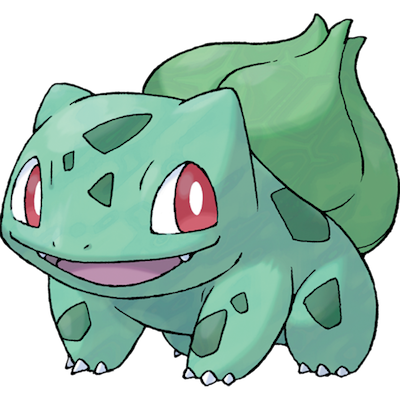

In [6]:
from PIL import Image
import requests

im = Image.open(requests.get("https://raw.githubusercontent.com/Purukitto/pokemon-data.json/master/images/pokedex/hires/001.png", stream=True).raw)
im

### Super simple download function!

In [7]:
def download_images(images, image_type):
    return [Image.open(requests.get(im["hires"], stream=True).raw).convert(image_type) for im in images]

### Create the collection, and use a custom transformation function to download images. We'll also use the ray backend, but you can switch backend = `python` to use the default one

In [8]:
collection = vexpresso.create(data=df, backend="ray")

2023-06-19 12:17:43,240	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265
2023-06-19 12:17:44.678 | INFO     | daft.context:runner:71 - Using RayRunner
2023-06-19 12:17:44.679 | WARNING  | daft.runners.ray_runner:__init__:552 - Ray has already been initialized, Daft will reuse the existing Ray context.
2023-06-19 12:17:44,679	INFO worker.py:956 -- Connecting to existing Ray cluster at address: 10.0.0.223:65059
2023-06-19 12:17:44,680	INFO worker.py:973 -- Calling ray.init() again after it has already been called.


In [9]:
collection.show(5)

idInt64,"nameStruct[chinese: Utf8, english: Utf8, french: Utf8, japanese: Utf8]",typeList[item:Utf8],"baseStruct[Attack: Int64, Defense: Int64, HP: Int64, Sp. Attack: Int64, Sp. Defense: Int64, Speed: Int64]",speciesUtf8,descriptionUtf8,"evolutionStruct[next: List[item:List[item:Utf8]], prev: List[item:Utf8]]","profileStruct[ability: List[item:List[item:Utf8]], egg: List[item:Utf8], gender: Utf8, height: Utf8, weight: Utf8]","imageStruct[hires: Utf8, sprite: Utf8, thumbnail: Utf8]"
1,"{'chinese': '妙蛙种子', 'english': 'Bulbasaur', 'french': 'Bu...","['Grass', 'Poison']","{'Attack': 49, 'Defense': 49, 'HP': 45, 'Sp. Attack': 65,...",Seed Pokémon,Bulbasaur can be seen napping in bright sunlight. There i...,"{'next': [['2', 'Level 16']], 'prev': None}","{'ability': [['Overgrow', 'false'], ['Chlorophyll', 'true...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...
2,"{'chinese': '妙蛙草', 'english': 'Ivysaur', 'french': 'Herbi...","['Grass', 'Poison']","{'Attack': 62, 'Defense': 63, 'HP': 60, 'Sp. Attack': 80,...",Seed Pokémon,There is a bud on this Pokémon’s back. To support its wei...,"{'next': [['3', 'Level 32']], 'prev': ['1', 'Level 16']}","{'ability': [['Overgrow', 'false'], ['Chlorophyll', 'true...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...
3,"{'chinese': '妙蛙花', 'english': 'Venusaur', 'french': 'Flor...","['Grass', 'Poison']","{'Attack': 82, 'Defense': 83, 'HP': 80, 'Sp. Attack': 100...",Seed Pokémon,There is a large flower on Venusaur’s back. The flower is...,"{'next': None, 'prev': ['2', 'Level 32']}","{'ability': [['Overgrow', 'false'], ['Chlorophyll', 'true...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...
4,"{'chinese': '小火龙', 'english': 'Charmander', 'french': 'Sa...",['Fire'],"{'Attack': 52, 'Defense': 43, 'HP': 39, 'Sp. Attack': 60,...",Lizard Pokémon,The flame that burns at the tip of its tail is an indicat...,"{'next': [['5', 'Level 16']], 'prev': None}","{'ability': [['Blaze', 'false'], ['Solar Power', 'true']]...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...
5,"{'chinese': '火恐龙', 'english': 'Charmeleon', 'french': 'Re...",['Fire'],"{'Attack': 64, 'Defense': 58, 'HP': 58, 'Sp. Attack': 80,...",Flame Pokémon,Charmeleon mercilessly destroys its foes using its sharp ...,"{'next': [['6', 'Level 36']], 'prev': ['4', 'Level 16']}","{'ability': [['Blaze', 'false'], ['Solar Power', 'true']]...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...



#### For the call below, we want to pass in the image dictionaries in the column `image`, but we also want to specify `image_type` to be RGB

In [10]:
collection = collection.apply(download_images, collection["image"], image_type="RGB", to="downloaded_image", lazy=False, datatype=daft.DataType.python())

In [11]:
collection["downloaded_image"].show(3)

+--------------------+
| downloaded_image   |
| Python             |
+====================+
| <PIL.Image.Image   |
| image mode=RGB     |
| size=400x400 at    |
| 0x7F86741...       |
+--------------------+
| <PIL.Image.Image   |
| image mode=RGB     |
| size=400x400 at    |
| 0x7F86741...       |
+--------------------+
| <PIL.Image.Image   |
| image mode=RGB     |
| size=400x400 at    |
| 0x7F86741...       |
+--------------------+
(Showing first 3 rows)

### Lets use a multimodal Clip Embeddings model to query images

In [12]:
from PIL import Image
import requests
from transformers import CLIPModel, CLIPProcessor, CLIPTokenizerFast
import torch
    
class ClipEmbeddingsFunction:
    def __init__(self):

        self.model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.tokenizer = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch32")
        self.device = torch.device('cpu')

        if torch.cuda.is_available():
            self.device = torch.device('cuda')
            self.model = self.model.to(self.device)

    def __call__(self, inp, inp_type):
        if inp_type == "image":
            inputs = self.processor(images=inp, return_tensors="pt", padding=True)['pixel_values'].to(self.device)
            return self.model.get_image_features(inputs).detach().cpu().numpy()
        if inp_type == "text":
            inputs = self.tokenizer(inp, padding=True, return_tensors="pt")
            inputs["input_ids"] = inputs["input_ids"].to(self.device)
            inputs["attention_mask"] = inputs["attention_mask"].to(self.device)
            return self.model.get_text_features(**inputs).detach().cpu().numpy()

/home/shyam/miniconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


By default we'll disable gpu usage, but this will be alot faster if you have access to a gpu!

In [13]:
resource_request = ResourceRequest(num_gpus=0)
# for gpu usage:
# resource_request = ResourceRequest(num_gpus=1)

In [14]:
collection = collection.embed(
    "downloaded_image",
    embedding_fn=ClipEmbeddingsFunction,
    inp_type="image",
    to="clip_embeddings",
    resource_request = resource_request
).execute()

In [15]:
collection = collection.execute()

#### This can also be done with the `apply` function

In [16]:
# collection = collection.apply(ClipEmbeddingsFunction, collection["downloaded_image"], inp_type="image", to="image_embeddings", resource_request = ResourceRequest(num_gpus=1)).execute()

In [17]:
collection.show(5)

idInt64,"nameStruct[chinese: Utf8, english: Utf8, french: Utf8, japanese: Utf8]",typeList[item:Utf8],"baseStruct[Attack: Int64, Defense: Int64, HP: Int64, Sp. Attack: Int64, Sp. Defense: Int64, Speed: Int64]",speciesUtf8,descriptionUtf8,"evolutionStruct[next: List[item:List[item:Utf8]], prev: List[item:Utf8]]","profileStruct[ability: List[item:List[item:Utf8]], egg: List[item:Utf8], gender: Utf8, height: Utf8, weight: Utf8]","imageStruct[hires: Utf8, sprite: Utf8, thumbnail: Utf8]",clip_embeddingsPython
1,"{'chinese': '妙蛙种子', 'english': 'Bulbasaur', 'french': 'Bu...","['Grass', 'Poison']","{'Attack': 49, 'Defense': 49, 'HP': 45, 'Sp. Attack': 65,...",Seed Pokémon,Bulbasaur can be seen napping in bright sunlight. There i...,"{'next': [['2', 'Level 16']], 'prev': None}","{'ability': [['Overgrow', 'false'], ['Chlorophyll', 'true...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"
2,"{'chinese': '妙蛙草', 'english': 'Ivysaur', 'french': 'Herbi...","['Grass', 'Poison']","{'Attack': 62, 'Defense': 63, 'HP': 60, 'Sp. Attack': 80,...",Seed Pokémon,There is a bud on this Pokémon’s back. To support its wei...,"{'next': [['3', 'Level 32']], 'prev': ['1', 'Level 16']}","{'ability': [['Overgrow', 'false'], ['Chlorophyll', 'true...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"
3,"{'chinese': '妙蛙花', 'english': 'Venusaur', 'french': 'Flor...","['Grass', 'Poison']","{'Attack': 82, 'Defense': 83, 'HP': 80, 'Sp. Attack': 100...",Seed Pokémon,There is a large flower on Venusaur’s back. The flower is...,"{'next': None, 'prev': ['2', 'Level 32']}","{'ability': [['Overgrow', 'false'], ['Chlorophyll', 'true...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"
4,"{'chinese': '小火龙', 'english': 'Charmander', 'french': 'Sa...",['Fire'],"{'Attack': 52, 'Defense': 43, 'HP': 39, 'Sp. Attack': 60,...",Lizard Pokémon,The flame that burns at the tip of its tail is an indicat...,"{'next': [['5', 'Level 16']], 'prev': None}","{'ability': [['Blaze', 'false'], ['Solar Power', 'true']]...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"
5,"{'chinese': '火恐龙', 'english': 'Charmeleon', 'french': 'Re...",['Fire'],"{'Attack': 64, 'Defense': 58, 'HP': 58, 'Sp. Attack': 80,...",Flame Pokémon,Charmeleon mercilessly destroys its foes using its sharp ...,"{'next': [['6', 'Level 36']], 'prev': ['4', 'Level 16']}","{'ability': [['Blaze', 'false'], ['Solar Power', 'true']]...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"


### Query Images with text

#### Querying for red pokemon

In [18]:
red_pokemon = collection.query(
                "clip_embeddings",
                query="Fire Pokemon that has red and orange skin and looks like a lizard",
                k=10,
                inp_type="text"
             ).execute()
red_pokemon.show(5)

idInt64,"nameStruct[chinese: Utf8, english: Utf8, french: Utf8, japanese: Utf8]",typeList[item:Utf8],"baseStruct[Attack: Int64, Defense: Int64, HP: Int64, Sp. Attack: Int64, Sp. Defense: Int64, Speed: Int64]",speciesUtf8,descriptionUtf8,"evolutionStruct[next: List[item:List[item:Utf8]], prev: List[item:Utf8]]","profileStruct[ability: List[item:List[item:Utf8]], egg: List[item:Utf8], gender: Utf8, height: Utf8, weight: Utf8]","imageStruct[hires: Utf8, sprite: Utf8, thumbnail: Utf8]",clip_embeddingsPython
5,"{'chinese': '火恐龙', 'english': 'Charmeleon', 'french': 'Re...",['Fire'],"{'Attack': 64, 'Defense': 58, 'HP': 58, 'Sp. Attack': 80,...",Flame Pokémon,Charmeleon mercilessly destroys its foes using its sharp ...,"{'next': [['6', 'Level 36']], 'prev': ['4', 'Level 16']}","{'ability': [['Blaze', 'false'], ['Solar Power', 'true']]...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"
126,"{'chinese': '鸭嘴火兽', 'english': 'Magmar', 'french': 'Magma...",['Fire'],"{'Attack': 95, 'Defense': 57, 'HP': 65, 'Sp. Attack': 100...",Spitfire Pokémon,"The hotter the place, the better they feel. Magmar in Alo...","{'next': [['467', 'trade holding Magmarizer']], 'prev': [...","{'ability': [['Flame Body', 'false'], ['Vital Spirit', 't...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"
4,"{'chinese': '小火龙', 'english': 'Charmander', 'french': 'Sa...",['Fire'],"{'Attack': 52, 'Defense': 43, 'HP': 39, 'Sp. Attack': 60,...",Lizard Pokémon,The flame that burns at the tip of its tail is an indicat...,"{'next': [['5', 'Level 16']], 'prev': None}","{'ability': [['Blaze', 'false'], ['Solar Power', 'true']]...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"
146,"{'chinese': '火焰鸟', 'english': 'Moltres', 'french': 'Sulfu...","['Fire', 'Flying']","{'Attack': 100, 'Defense': 90, 'HP': 90, 'Sp. Attack': 12...",Flame Pokémon,Moltres is a legendary bird Pokémon that has the ability ...,"{'next': None, 'prev': None}","{'ability': [['Pressure', 'false'], ['Flame Body', 'true'...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"
6,"{'chinese': '喷火龙', 'english': 'Charizard', 'french': 'Dra...","['Fire', 'Flying']","{'Attack': 84, 'Defense': 78, 'HP': 78, 'Sp. Attack': 109...",Flame Pokémon,Charizard flies around the sky in search of powerful oppo...,"{'next': None, 'prev': ['5', 'Level 36']}","{'ability': [['Blaze', 'false'], ['Solar Power', 'true']]...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"


In [19]:
red_pokemon = collection.query("clip_embeddings", "Fire Pokemon that has red and orange skin and looks like a lizard", k=10, inp_type="text") \
                        .filter({"base.Attack":{"gte":60}}) \
                        .execute()
red_pokemon.show(5)

idInt64,"nameStruct[chinese: Utf8, english: Utf8, french: Utf8, japanese: Utf8]",typeList[item:Utf8],"baseStruct[Attack: Int64, Defense: Int64, HP: Int64, Sp. Attack: Int64, Sp. Defense: Int64, Speed: Int64]",speciesUtf8,descriptionUtf8,"evolutionStruct[next: List[item:List[item:Utf8]], prev: List[item:Utf8]]","profileStruct[ability: List[item:List[item:Utf8]], egg: List[item:Utf8], gender: Utf8, height: Utf8, weight: Utf8]","imageStruct[hires: Utf8, sprite: Utf8, thumbnail: Utf8]",clip_embeddingsPython
5,"{'chinese': '火恐龙', 'english': 'Charmeleon', 'french': 'Re...",['Fire'],"{'Attack': 64, 'Defense': 58, 'HP': 58, 'Sp. Attack': 80,...",Flame Pokémon,Charmeleon mercilessly destroys its foes using its sharp ...,"{'next': [['6', 'Level 36']], 'prev': ['4', 'Level 16']}","{'ability': [['Blaze', 'false'], ['Solar Power', 'true']]...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"
126,"{'chinese': '鸭嘴火兽', 'english': 'Magmar', 'french': 'Magma...",['Fire'],"{'Attack': 95, 'Defense': 57, 'HP': 65, 'Sp. Attack': 100...",Spitfire Pokémon,"The hotter the place, the better they feel. Magmar in Alo...","{'next': [['467', 'trade holding Magmarizer']], 'prev': [...","{'ability': [['Flame Body', 'false'], ['Vital Spirit', 't...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"
146,"{'chinese': '火焰鸟', 'english': 'Moltres', 'french': 'Sulfu...","['Fire', 'Flying']","{'Attack': 100, 'Defense': 90, 'HP': 90, 'Sp. Attack': 12...",Flame Pokémon,Moltres is a legendary bird Pokémon that has the ability ...,"{'next': None, 'prev': None}","{'ability': [['Pressure', 'false'], ['Flame Body', 'true'...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"
6,"{'chinese': '喷火龙', 'english': 'Charizard', 'french': 'Dra...","['Fire', 'Flying']","{'Attack': 84, 'Defense': 78, 'HP': 78, 'Sp. Attack': 109...",Flame Pokémon,Charizard flies around the sky in search of powerful oppo...,"{'next': None, 'prev': ['5', 'Level 36']}","{'ability': [['Blaze', 'false'], ['Solar Power', 'true']]...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"
99,"{'chinese': '巨钳蟹', 'english': 'Kingler', 'french': 'Krabb...",['Water'],"{'Attack': 130, 'Defense': 115, 'HP': 55, 'Sp. Attack': 5...",Pincer Pokémon,"Kingler has an enormous, oversized claw. It waves this hu...","{'next': None, 'prev': ['98', 'Level 28']}","{'ability': [['Hyper Cutter', 'false'], ['Shell Armor', '...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"


#### Querying for pokemon that look like plants

In [20]:
plant_pokemon = collection.query("clip_embeddings", query="Pokemon that looks like a plant", k=10, inp_type="text") \
                        .execute()
plant_pokemon.show(5)

idInt64,"nameStruct[chinese: Utf8, english: Utf8, french: Utf8, japanese: Utf8]",typeList[item:Utf8],"baseStruct[Attack: Int64, Defense: Int64, HP: Int64, Sp. Attack: Int64, Sp. Defense: Int64, Speed: Int64]",speciesUtf8,descriptionUtf8,"evolutionStruct[next: List[item:List[item:Utf8]], prev: List[item:Utf8]]","profileStruct[ability: List[item:List[item:Utf8]], egg: List[item:Utf8], gender: Utf8, height: Utf8, weight: Utf8]","imageStruct[hires: Utf8, sprite: Utf8, thumbnail: Utf8]",clip_embeddingsPython
43,"{'chinese': '走路草', 'english': 'Oddish', 'french': 'Mysthe...","['Grass', 'Poison']","{'Attack': 50, 'Defense': 55, 'HP': 45, 'Sp. Attack': 75,...",Weed Pokémon,"Oddish searches for fertile, nutrient-rich soil, then pla...","{'next': [['44', 'Level 21']], 'prev': None}","{'ability': [['Chlorophyll', 'false'], ['Run Away', 'true...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"
103,"{'chinese': '椰蛋树', 'english': 'Exeggutor', 'french': 'Noa...","['Grass', 'Psychic']","{'Attack': 95, 'Defense': 85, 'HP': 95, 'Sp. Attack': 125...",Coconut Pokémon,Each of its three heads has its own thoughts. When they w...,"{'next': None, 'prev': ['102', 'use Leaf Stone']}","{'ability': [['Chlorophyll', 'false'], ['Harvest', 'true'...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"
69,"{'chinese': '喇叭芽', 'english': 'Bellsprout', 'french': 'Ch...","['Grass', 'Poison']","{'Attack': 75, 'Defense': 35, 'HP': 50, 'Sp. Attack': 70,...",Flower Pokémon,Bellsprout’s thin and flexible body lets it bend and sway...,"{'next': [['70', 'Level 21']], 'prev': None}","{'ability': [['Chlorophyll', 'false'], ['Gluttony', 'true...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"
71,"{'chinese': '大食花', 'english': 'Victreebel', 'french': 'Em...","['Grass', 'Poison']","{'Attack': 105, 'Defense': 65, 'HP': 80, 'Sp. Attack': 10...",Flycatcher Pokémon,Victreebel has a long vine that extends from its head. Th...,"{'next': None, 'prev': ['70', 'use Leaf Stone']}","{'ability': [['Chlorophyll', 'false'], ['Gluttony', 'true...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"
3,"{'chinese': '妙蛙花', 'english': 'Venusaur', 'french': 'Flor...","['Grass', 'Poison']","{'Attack': 82, 'Defense': 83, 'HP': 80, 'Sp. Attack': 100...",Seed Pokémon,There is a large flower on Venusaur’s back. The flower is...,"{'next': None, 'prev': ['2', 'Level 32']}","{'ability': [['Overgrow', 'false'], ['Chlorophyll', 'true...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"


#### Querying for Plant pokemon, but filtering out Bug pokemon

##### We can use a custom filter or the built in `notcontains` method!

```python
# using custom filter
def filter_by_type(typ, avoid_type):
    return avoid_type not in typ

filter_condition = {
    "type": {
        "custom": (filter_by_type, {"avoid_type":"Bug"})
    }
}
```

In [21]:
filter_condition = {
    "type": {
        "notcontains": "Bug"
    }
}

In [22]:
plant_pokemon = collection.query(
    "clip_embeddings",
    query="Pokemon that looks like a plant",
    k=10,
    inp_type="text",
    filter_conditions=filter_condition
)
plant_pokemon.show(5)

idInt64,"nameStruct[chinese: Utf8, english: Utf8, french: Utf8, japanese: Utf8]",typeList[item:Utf8],"baseStruct[Attack: Int64, Defense: Int64, HP: Int64, Sp. Attack: Int64, Sp. Defense: Int64, Speed: Int64]",speciesUtf8,descriptionUtf8,"evolutionStruct[next: List[item:List[item:Utf8]], prev: List[item:Utf8]]","profileStruct[ability: List[item:List[item:Utf8]], egg: List[item:Utf8], gender: Utf8, height: Utf8, weight: Utf8]","imageStruct[hires: Utf8, sprite: Utf8, thumbnail: Utf8]",clip_embeddingsPython
43,"{'chinese': '走路草', 'english': 'Oddish', 'french': 'Mysthe...","['Grass', 'Poison']","{'Attack': 50, 'Defense': 55, 'HP': 45, 'Sp. Attack': 75,...",Weed Pokémon,"Oddish searches for fertile, nutrient-rich soil, then pla...","{'next': [['44', 'Level 21']], 'prev': None}","{'ability': [['Chlorophyll', 'false'], ['Run Away', 'true...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"
103,"{'chinese': '椰蛋树', 'english': 'Exeggutor', 'french': 'Noa...","['Grass', 'Psychic']","{'Attack': 95, 'Defense': 85, 'HP': 95, 'Sp. Attack': 125...",Coconut Pokémon,Each of its three heads has its own thoughts. When they w...,"{'next': None, 'prev': ['102', 'use Leaf Stone']}","{'ability': [['Chlorophyll', 'false'], ['Harvest', 'true'...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"
69,"{'chinese': '喇叭芽', 'english': 'Bellsprout', 'french': 'Ch...","['Grass', 'Poison']","{'Attack': 75, 'Defense': 35, 'HP': 50, 'Sp. Attack': 70,...",Flower Pokémon,Bellsprout’s thin and flexible body lets it bend and sway...,"{'next': [['70', 'Level 21']], 'prev': None}","{'ability': [['Chlorophyll', 'false'], ['Gluttony', 'true...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"
71,"{'chinese': '大食花', 'english': 'Victreebel', 'french': 'Em...","['Grass', 'Poison']","{'Attack': 105, 'Defense': 65, 'HP': 80, 'Sp. Attack': 10...",Flycatcher Pokémon,Victreebel has a long vine that extends from its head. Th...,"{'next': None, 'prev': ['70', 'use Leaf Stone']}","{'ability': [['Chlorophyll', 'false'], ['Gluttony', 'true...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"
3,"{'chinese': '妙蛙花', 'english': 'Venusaur', 'french': 'Flor...","['Grass', 'Poison']","{'Attack': 82, 'Defense': 83, 'HP': 80, 'Sp. Attack': 100...",Seed Pokémon,There is a large flower on Venusaur’s back. The flower is...,"{'next': None, 'prev': ['2', 'Level 32']}","{'ability': [['Overgrow', 'false'], ['Chlorophyll', 'true...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"


#### Lets Query based on images!

With Vexpresso, we can embed any data, and we can also query any data!

Lets query with Bulbasaur!

In [23]:
images = collection["downloaded_image"].to_list()

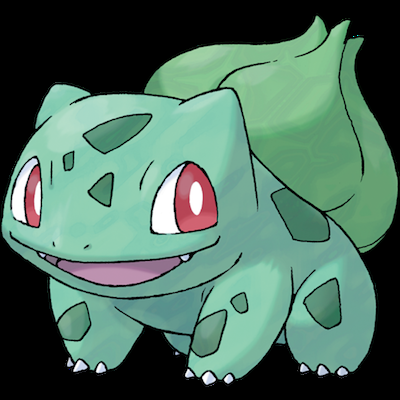

In [24]:
images[0]

In [25]:
bulbasaur = collection.query(
    "clip_embeddings",
    query=images[0],
    k=10,
    inp_type="image",
)
bulbasaur.show(5)

idInt64,"nameStruct[chinese: Utf8, english: Utf8, french: Utf8, japanese: Utf8]",typeList[item:Utf8],"baseStruct[Attack: Int64, Defense: Int64, HP: Int64, Sp. Attack: Int64, Sp. Defense: Int64, Speed: Int64]",speciesUtf8,descriptionUtf8,"evolutionStruct[next: List[item:List[item:Utf8]], prev: List[item:Utf8]]","profileStruct[ability: List[item:List[item:Utf8]], egg: List[item:Utf8], gender: Utf8, height: Utf8, weight: Utf8]","imageStruct[hires: Utf8, sprite: Utf8, thumbnail: Utf8]",clip_embeddingsPython
1,"{'chinese': '妙蛙种子', 'english': 'Bulbasaur', 'french': 'Bu...","['Grass', 'Poison']","{'Attack': 49, 'Defense': 49, 'HP': 45, 'Sp. Attack': 65,...",Seed Pokémon,Bulbasaur can be seen napping in bright sunlight. There i...,"{'next': [['2', 'Level 16']], 'prev': None}","{'ability': [['Overgrow', 'false'], ['Chlorophyll', 'true...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"
2,"{'chinese': '妙蛙草', 'english': 'Ivysaur', 'french': 'Herbi...","['Grass', 'Poison']","{'Attack': 62, 'Defense': 63, 'HP': 60, 'Sp. Attack': 80,...",Seed Pokémon,There is a bud on this Pokémon’s back. To support its wei...,"{'next': [['3', 'Level 32']], 'prev': ['1', 'Level 16']}","{'ability': [['Overgrow', 'false'], ['Chlorophyll', 'true...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"
30,"{'chinese': '尼多娜', 'english': 'Nidorina', 'french': 'Nido...",['Poison'],"{'Attack': 62, 'Defense': 67, 'HP': 70, 'Sp. Attack': 55,...",Poison Pin Pokémon,"When Nidorina are with their friends or family, they keep...","{'next': [['31', 'use Moon Stone']], 'prev': ['29', 'Leve...","{'ability': [['Poison Point', 'false'], ['Rivalry', 'fals...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"
55,"{'chinese': '哥达鸭', 'english': 'Golduck', 'french': 'Akwak...",['Water'],"{'Attack': 82, 'Defense': 78, 'HP': 80, 'Sp. Attack': 95,...",Duck Pokémon,"A professional swimmer, it can continue swimming for two ...","{'next': None, 'prev': ['54', 'Level 33']}","{'ability': [['Damp', 'false'], ['Cloud Nine', 'false'], ...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"
31,"{'chinese': '尼多后', 'english': 'Nidoqueen', 'french': 'Nid...","['Poison', 'Ground']","{'Attack': 92, 'Defense': 87, 'HP': 90, 'Sp. Attack': 75,...",Drill Pokémon,Nidoqueen’s body is encased in extremely hard scales. It ...,"{'next': None, 'prev': ['30', 'use Moon Stone']}","{'ability': [['Poison Point', 'false'], ['Rivalry', 'fals...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"


#### Lets Query based on images + texts!
In the example above, we were able to query pokemon that kinda look like the image of bulbasaur! However, sometimes images aren't enough and we want to add more descriptions to filter by.

Because CLIP embeds images and text in the same embedding space, we can average both an image and a text description together to get a more complex / mixed query! To do this, we need to embed our queries directly.

This can help narrow down queries through pure text + image search! For example, lets add a text query "Looks like a plant" to return Pokemon that not only look like bulbasaur, but are also plant-like



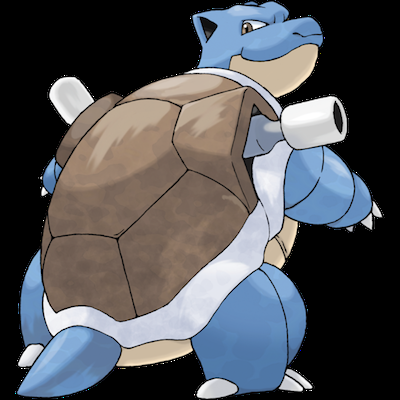

In [26]:
image_query = images[8] # Bulbasaur
image_query

In [27]:
text_query = "Has fins and looks like a fish"

In [28]:
text_embedding = collection.embed_query(text_query, embedding_fn="clip_embeddings", inp_type="text")
image_embedding = collection.embed_query(image_query, embedding_fn="clip_embeddings", inp_type="image")

In [29]:
query_embedding = text_embedding*0.5 + image_embedding*0.5

In [30]:
bulbasaur = collection.query(
    "clip_embeddings",
    query_embedding=query_embedding,
    k=10,
)
bulbasaur.show(5)

idInt64,"nameStruct[chinese: Utf8, english: Utf8, french: Utf8, japanese: Utf8]",typeList[item:Utf8],"baseStruct[Attack: Int64, Defense: Int64, HP: Int64, Sp. Attack: Int64, Sp. Defense: Int64, Speed: Int64]",speciesUtf8,descriptionUtf8,"evolutionStruct[next: List[item:List[item:Utf8]], prev: List[item:Utf8]]","profileStruct[ability: List[item:List[item:Utf8]], egg: List[item:Utf8], gender: Utf8, height: Utf8, weight: Utf8]","imageStruct[hires: Utf8, sprite: Utf8, thumbnail: Utf8]",clip_embeddingsPython
9,"{'chinese': '水箭龟', 'english': 'Blastoise', 'french': 'Tor...",['Water'],"{'Attack': 83, 'Defense': 100, 'HP': 79, 'Sp. Attack': 85...",Shellfish Pokémon,Blastoise has water spouts that protrude from its shell. ...,"{'next': None, 'prev': ['8', 'Level 36']}","{'ability': [['Torrent', 'false'], ['Rain Dish', 'true']]...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"
31,"{'chinese': '尼多后', 'english': 'Nidoqueen', 'french': 'Nid...","['Poison', 'Ground']","{'Attack': 92, 'Defense': 87, 'HP': 90, 'Sp. Attack': 75,...",Drill Pokémon,Nidoqueen’s body is encased in extremely hard scales. It ...,"{'next': None, 'prev': ['30', 'use Moon Stone']}","{'ability': [['Poison Point', 'false'], ['Rivalry', 'fals...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"
8,"{'chinese': '卡咪龟', 'english': 'Wartortle', 'french': 'Car...",['Water'],"{'Attack': 63, 'Defense': 80, 'HP': 59, 'Sp. Attack': 65,...",Turtle Pokémon,"Its tail is large and covered with a rich, thick fur. The...","{'next': [['9', 'Level 36']], 'prev': ['7', 'Level 16']}","{'ability': [['Torrent', 'false'], ['Rain Dish', 'true']]...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"
7,"{'chinese': '杰尼龟', 'english': 'Squirtle', 'french': 'Cara...",['Water'],"{'Attack': 48, 'Defense': 65, 'HP': 44, 'Sp. Attack': 50,...",Tiny Turtle Pokémon,Squirtle’s shell is not merely used for protection. The s...,"{'next': [['8', 'Level 16']], 'prev': None}","{'ability': [['Torrent', 'false'], ['Rain Dish', 'true']]...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"
27,"{'chinese': '穿山鼠', 'english': 'Sandshrew', 'french': 'Sab...",['Ground'],"{'Attack': 75, 'Defense': 85, 'HP': 50, 'Sp. Attack': 20,...",Mouse Pokémon,"When its skin gets wrinkled from moisture, it heads for a...","{'next': [['28', 'Level 22']], 'prev': None}","{'ability': [['Sand Veil', 'false'], ['Sand Rush', 'true'...",{'hires': 'https://raw.githubusercontent.com/Purukitto/po...,"<np.ndarrayshape=(512,)dtype=float32>"


As you can see, we now get a mix of pokemon that not only look like bulbasaur, but also pokemon that are plant-like.

#### Lets setup a gradio demo!

In [31]:
def find_image_vectors(text_query, image_query, state):
    if text_query is None and image_query is None:
        raise ValueError("Image or text query must be provided")
    embeddings = []
    if text_query is not None:
        embeddings.append(collection.embed_query(text_query, embedding_fn="clip_embeddings", inp_type="text"))
    if image_query is not None:
        embeddings.append(collection.embed_query(image_query, embedding_fn="clip_embeddings", inp_type="image"))

    if len(embeddings) > 1:
        query_embedding = 0.5*embeddings[0] + 0.5*embeddings[1]
    else:
        query_embedding = embeddings[0]

    queried = collection.query(
        "clip_embeddings",
        query_embedding=query_embedding,
        k=10,
        inp_type="text",
    ).execute()
    if state is not None and len(state) > 0:
        for filt in state:
            queried = queried.filter(filter_conditions=filt)
    return queried["downloaded_image"].to_list()[:4]

In [33]:
import gradio as gr

def add_filter(state, filter_var, filter_method, filter_value):
    f = {filter_var:{filter_method:filter_value}}
    state.append(f)
    return f"{state}"

def remove_row(state, row):
    row = max(row, 0)
    if int(row) < len(state) and len(state) > 0:
        del state[int(row)]
    return f"{state}"

with gr.Blocks() as demo:
    state = gr.State([])
    with gr.Row():
        with gr.Column():
            gr.Markdown(
            """
                ### Query Input! Add either a text prompt or upload an image, or add both to average the predictions.
            """)
            vector_query = gr.Textbox(placeholder="Type in a text prompt! Ex: Looks like a plant", show_label=False)
            image_query = gr.Image(show_label=False)
        with gr.Column():
            gr.Markdown(
            """
                ### Filter method. Use this to filter based on metadata fields
            """)
            filter_var = gr.Textbox(label="filter_var")
            filter_method = gr.Dropdown(choices=[
                    "eq", "neq", "gt", "gte", "lt", "lte", "isin", "notin", "contains", "notcontains"
                ],
                label="filter_method"
            )
            filter_value = gr.Textbox(label="filter_value")
        with gr.Column():
            gr.Markdown(
            """
                ### Current Filter Methods
            """)
            current_filters = gr.Textbox(label="Current Filters")
            filter_button = gr.Button("Add filter")
        filter_button.click(fn=add_filter, inputs=[state, filter_var, filter_method, filter_value], outputs=current_filters)

    with gr.Row():
        button = gr.Button("Submit")
    with gr.Row():
        gallery = gr.Gallery(
            label="Queried Pokemon!", show_label=False, elem_id="gallery"
        ).style(columns=[2], rows=[2], object_fit="contain", height="auto")
    button.click(find_image_vectors, inputs=[vector_query, image_query, state], outputs=[gallery])
    gr.Examples(
        examples=[
            ["Turtle pokemon, has blue skin", None, []],
            ["Looks like a plant", "data/gradio-demo/bulbasaur.png", []],
            [None, "data/gradio-demo/charmander.png", []],
            [None, "data/gradio-demo/pikachu-dog.jpg", []],
            [None, "data/gradio-demo/mewtwo.jpeg", []],
        ],
        inputs=[vector_query, image_query, state],
        outputs=[gallery],
        fn=find_image_vectors,
        cache_examples=True,
    )

demo.launch()

/home/shyam/miniconda3/envs/py39/lib/python3.9/site-packages/gradio/components/gallery.py:205: UserWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  warnings.warn(
/home/shyam/miniconda3/envs/py39/lib/python3.9/site-packages/gradio/helpers.py:215: UserWarning: Examples are being cached but not all input components have example values. This may result in an exception being thrown by your function. If you do get an error while caching examples, make sure all of your inputs have example values for all of your examples or you provide default values for those particular parameters in your function.
  warnings.warn(


Caching examples at: '/home/shyam/Code/vexpresso/examples/gradio_cached_examples/49'
Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
